### Importing libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="darkgrid");sns.set(rc={'figure.figsize':(14,8)})
import re
import nltk

#### Some usefull function

In [10]:
# import time
# import big_o

# def get_execution_time(func):
#     start_time = time.time()
#     func()
#     end_time = time.time()
#     return end_time - start_time

# def get_big_o(func, test_data=None, n_repeats=1):
#     data_generator = lambda _: test_data
#     best, others = big_o.big_o(func, data_generator, n_repeats=n_repeats)
#     print(f"Best: {best}")
#     print()
#     for class_, residuals in others.items():
#         print("Class:", type(class_))
#         print('{!s:<60s}    (res: {:.2G})'.format(class_, residuals))
#     return best, others

### Import data

In [11]:
ORIGINAL_TRAINING_DATA = pd.read_csv('../data/original_train.csv')
ORIGINAL_TESTING_DATA = pd.read_csv('../data/original_test.csv')

- Train data

In [12]:
ORIGINAL_TRAINING_DATA

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...
...,...,...,...
6520,296675082267410433,Politics,'Photo: PM has laid a wreath at Martyrs Monume...
6521,306677536195231746,Sports,'The secret of the Chennai pitch - crumbling o...
6522,306451295307431937,Sports,@alinabhutto he isn't on Twitter either
6523,306088574221176832,Sports,'Which England player would you take out to di...


- Test data

In [13]:
ORIGINAL_TESTING_DATA

,TweetId,TweetText
0,306486520121012224,'28. The home side threaten again through Maso...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....
2,289531046037438464,'@Sochi2014 construction along the shores of t...
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...
...,...,...
2605,282023761044189184,'Qualifier 1 and Eliminator games will be play...
2606,303879735006601216,"@reesedward Hi Edward, it's not a #peacekeepin..."
2607,297956846046703616,'Perera was @SunRisersIPL first #IPL purchase ...
2608,304265049537658880,"'#SecKerry: Thanks to Senator @TimKaine, @RepR..."


### Handle missing values
No missing values

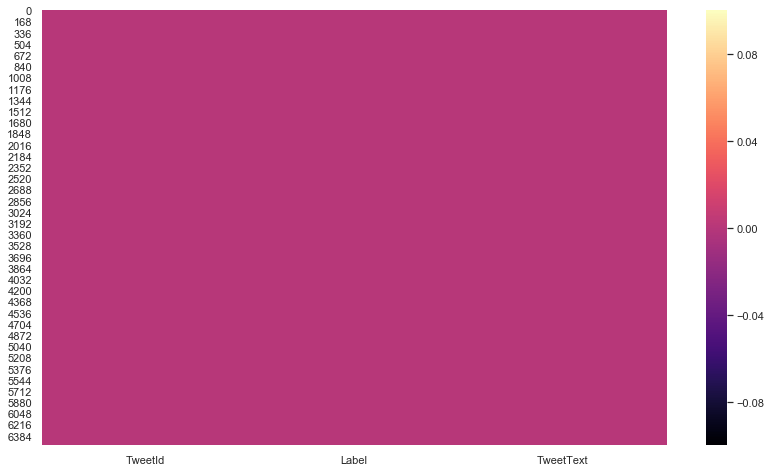

In [14]:
missv = ORIGINAL_TRAINING_DATA.isna()
sns.heatmap(missv, cmap='magma')

### Handle duplicates

- Origin shape

In [15]:
ORIGINAL_TRAINING_DATA.shape

(6525, 3)

- Shape without duplicates

In [16]:
ORIGINAL_TRAINING_DATA.TweetText.unique().shape

(6508,)

- Duplicated tweets

In [17]:
def get_all_duplicated_tweets():
    tweets = []
    duplicated_tweets = {}
    for i, tweet in enumerate(ORIGINAL_TRAINING_DATA.TweetText): #
        if tweet in tweets:
            try:
                duplicated_tweets[tweet] += 1
            except:
                duplicated_tweets[tweet] = 2
        else: tweets.append(tweet)
    
    return duplicated_tweets

def show_duplicated_tweets():
    duplicated_tweets = get_all_duplicated_tweets()
    for i, (key, value) in enumerate(duplicated_tweets.items()):
        print(f"{i} ({value} times): {key[:100]}...")

In [18]:
show_duplicated_tweets()

0 (2 times): 'Daily tickets for the Aegon International are on sale now! Get yours at: http://t.co/K6yDYuHO or by...
1 (2 times): 'RT @MazdaAus: Our great @ausgrandprix competition closes this Wednesday! For details click http://t...
2 (2 times): '2 mins added time. #CFC'...
3 (2 times): 'WATCH LIVE: Midweek Final Score brings you all the #bbcfootball action on BBC Red Button &amp; via ...
4 (3 times): 'RT @HouseofCommons: Prime Minister\u2019s Questions is coming up at midday. You can follow proceedi...
5 (3 times): 'Coaches: Check out the latest content from the High Performance Centres Coach Workshops: http://t.c...
6 (2 times): 'Buy your #AusGP general admission tickets before March 1 for early bird prices. #F1 #cantwaitforaus...
7 (2 times): 'Who is your BBL|02 MVP? http://t.co/ADle5YGo #BBL02'...
8 (2 times): '.@WhiteHouse Fact Sheet: Advancing Rights of #LGBT People Globally: http://t.co/dIpeJpOtFr @State_D...
9 (2 times): Here's an interactive route map of the BCIM Car Rally, K

### Correct Data (Trim apostrophes TweetText)

In [19]:
TRAINING_DATA = ORIGINAL_TRAINING_DATA.copy()

In [20]:
def trim_apostrophes(tweet):
    return tweet.strip("'")

TRAINING_DATA.TweetText = list(map(trim_apostrophes, list(TRAINING_DATA.TweetText)))

### Target Variable percentages

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017192FF6D48>],
      dtype=object)

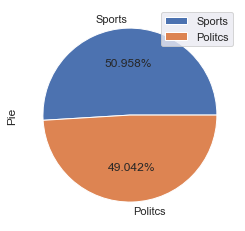

In [21]:
label_per = TRAINING_DATA['Label'].value_counts()/TRAINING_DATA.shape[0] *100
label_df = pd.DataFrame(list(label_per), index=['Sports', 'Politcs'], columns=['Pie'])
label_df.plot(kind='pie',subplots=True, figsize=(4, 4),autopct='%1.3f%%')

### Customize Data - Extract substrings with regular expressions (Mentions, hashtags, links, etc.)

In [22]:
def isRetweeted(tweet):
    if tweet[:2] == 'RT': return 1
    return 0

def retweeted2(tweet):
    if tweet[:2] == 'RT':
        return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
    return []

def get_mentions(tweet):
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def get_hashtags(tweet):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def get_links(tweet):
    return re.findall('(https?://\S+)', tweet)

def customize_data(original_data):
    
    customized_training_data = original_data.copy()
    
    new_columns_var_func = {"isRetweeted":isRetweeted,"RetweetedTo":retweeted2, "Mentioned":get_mentions, "Hashtags":get_hashtags, "Links":get_links}
    
    for var, func in new_columns_var_func.items():
        customized_training_data[var] = customized_training_data.TweetText.apply(func)
        
    return customized_training_data

In [23]:
TRAINING_DATA = customize_data(TRAINING_DATA)

In [24]:
TRAINING_DATA

,TweetId,Label,TweetText,isRetweeted,RetweetedTo,Mentioned,Hashtags,Links
0,304271250237304833,Politics,#SecKerry: The value of the @StateDept and @US...,0,[],"[@StateDept, @USAID]",[#SecKerry],[]
1,304834304222064640,Politics,@rraina1481 I fear so,0,[],[@rraina1481],[],[]
2,303568995880144898,Sports,Watch video highlights of the #wwc13 final bet...,0,[],[],[#wwc13],[http://t.co/lBXIIk3j]
3,304366580664528896,Sports,RT @chelscanlan: At Nitro Circus at #AlbertPar...,1,[@chelscanlan],"[@ausgrandprix, @ChadwickModels]","[#AlbertPark, #theymakeitlooksoeasy, #CantWait...",[]
4,296770931098009601,Sports,@cricketfox Always a good thing. Thanks for th...,0,[],[@cricketfox],[],[]
...,...,...,...,...,...,...,...,...
6520,296675082267410433,Politics,Photo: PM has laid a wreath at Martyrs Monumen...,0,[],[],"[#Algeria, #PMinAfrica]",[http://t.co/U2LZUHGs]
6521,306677536195231746,Sports,The secret of the Chennai pitch - crumbling on...,0,[],[],[],[http://t.co/T2GRLxUSoV]
6522,306451295307431937,Sports,@alinabhutto he isn't on Twitter either,0,[],[@alinabhutto],[],[]
6523,306088574221176832,Sports,Which England player would you take out to din...,0,[],"[@lukewright204, @joeroot05, @alexhales1, @jba...",[],[http://t.co/BT2fLZ35Px]


### Analysis extracted substrings

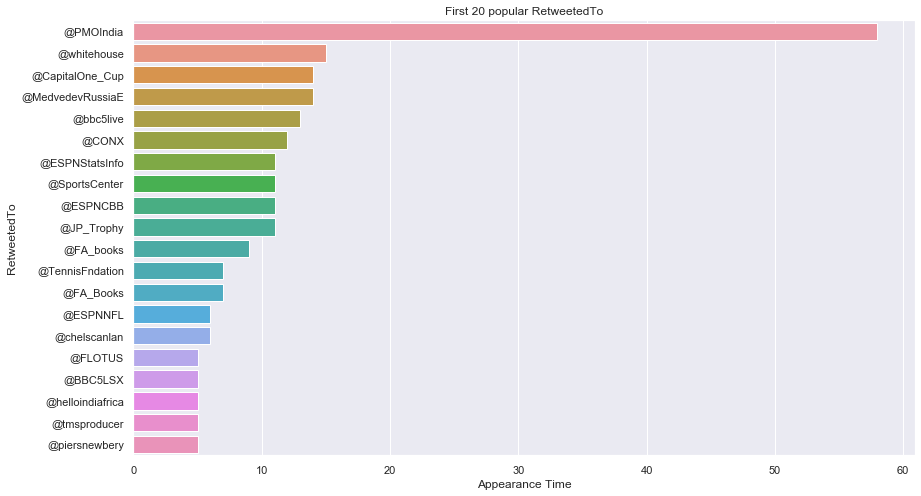

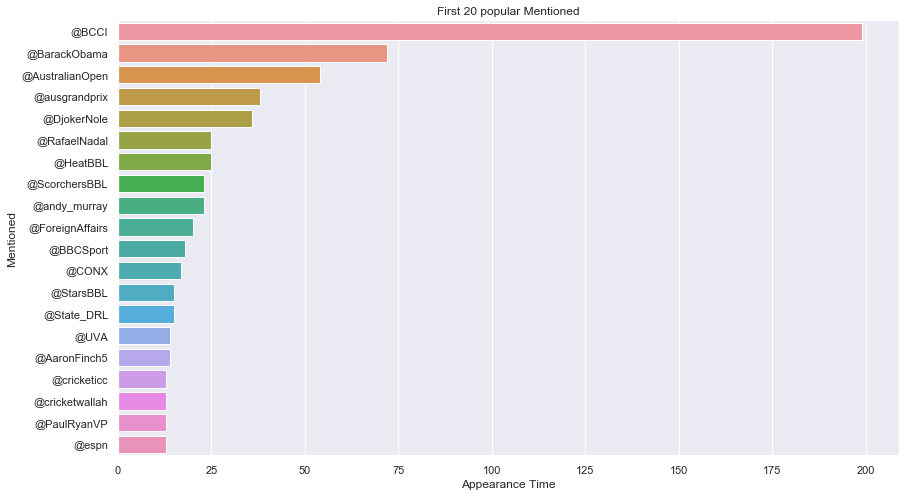

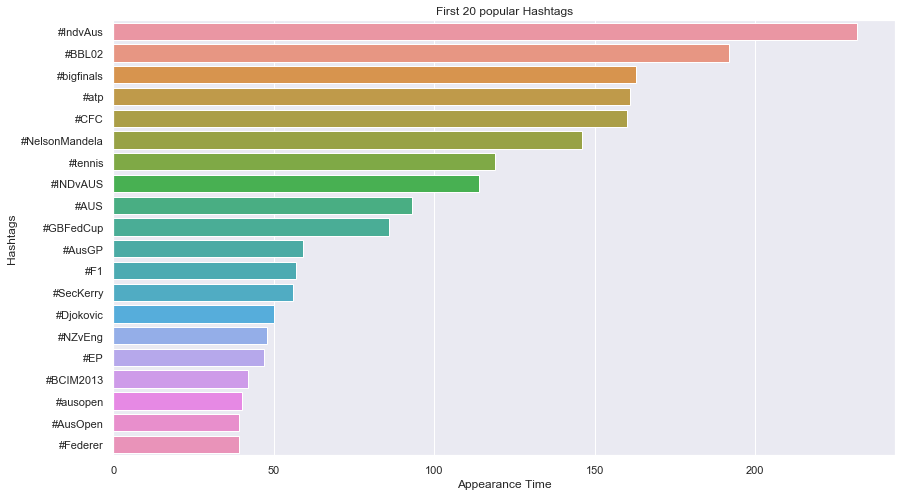

In [26]:
def get_all_values(column=None):
    
    if not column:
        raise TypeError('You must specify a columns to analyse')
        return
    
    list_dataframe = TRAINING_DATA.loc[TRAINING_DATA[column].apply(lambda x: x != []), [column]]
    column_dataframe = pd.DataFrame([value
                                     for list_value in list_dataframe[column]
                                     for value in list_value
                                    ], columns=[column])
    
    counts_dataframe = column_dataframe.groupby(column)\
                        .size().reset_index(name='Appearance Time')\
                        .sort_values('Appearance Time', ascending=False)\
                        .reset_index(drop=True)
    
    return counts_dataframe

def show_20_popular(column=None):
    
    if not column:
        raise TypeError('You must specify a columns to analyse')
        return
    
    _20_popular = get_all_values(column)[:20]
    
    ax = sns.barplot(data=_20_popular, x='Appearance Time', y=column, orient='h')
    plt.title(f"First 20 popular {column}")
    
show_20_popular('RetweetedTo'); plt.show()
show_20_popular('Mentioned'); plt.show()
show_20_popular('Hashtags')


### Clean unstructed text data (TweetText)

In [27]:
from nltk.tokenize import  RegexpTokenizer
from nltk.corpus import stopwords

1. Replace links with "webLink"

In [28]:
def handle_links(tweet):
    tweet = re.sub('(http://\S+)', 'web_link', tweet)
    tweet = re.sub('(bit.ly/\S+)', 'web_link', tweet)
    return tweet

2. Remove mentioned users

In [29]:
def handle_mentions(tweet):
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    return tweet

3. Remove punctuations, numbers and double spacing

In [30]:
def handle_punctuations_num_2sp(tweet):
    punctuations = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
    tweet = re.sub('([' + punctuations + ']+)', ' ', tweet)
    tweet = re.sub('([0-9]+)', '', tweet)
    tweet = re.sub('(\s+)', ' ', tweet)
    return tweet

4. Clean TweetText

In [31]:
try:
    stopwords = nltk.corpus.stopwords.words('english')
except:
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('english')
    
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem

def clean_tweet(tweet, bigrams=False):
    
    tweet = handle_links(tweet)
    tweet = handle_mentions(tweet)
    tweet = handle_punctuations_num_2sp(tweet)
    tweet = tweet.lower()
    tweet = tweet.split()
    
    tweet_words = [word for word in tweet if word not in stopwords]
    tweet_words = [word_rooter(word) if '#' not in word else word for word in tweet_words]
    
    if bigrams:
        tweet_words = tweet_words + [tweet_words[i] + '_' + tweet_words[i+1] for i in range(len(tweet_words)-1)]
        
    tweet = ' '.join(tweet_words)
    
    return tweet

In [32]:
TRAINING_DATA['CleanedText'] = TRAINING_DATA.TweetText.apply(clean_tweet)

### Applying Topic Modelling using scikit-learn

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import accuracy_score

vectorizer = CountVectorizer(max_df=0.98, min_df=10)
transform = vectorizer.fit_transform(TRAINING_DATA.CleanedText).toarray()
transform_feature_names = vectorizer.get_feature_names()

In [34]:
final_training_data = pd.DataFrame(transform, columns=transform_feature_names)

In [35]:
final_training_data['isRetweeted'] = TRAINING_DATA.isRetweeted
final_training_data['Label'] = TRAINING_DATA.Label

In [36]:
X_train = final_training_data.drop(['Label'], axis=1)
y_train = final_training_data.Label

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Text(0, 0.5, 'Topics')

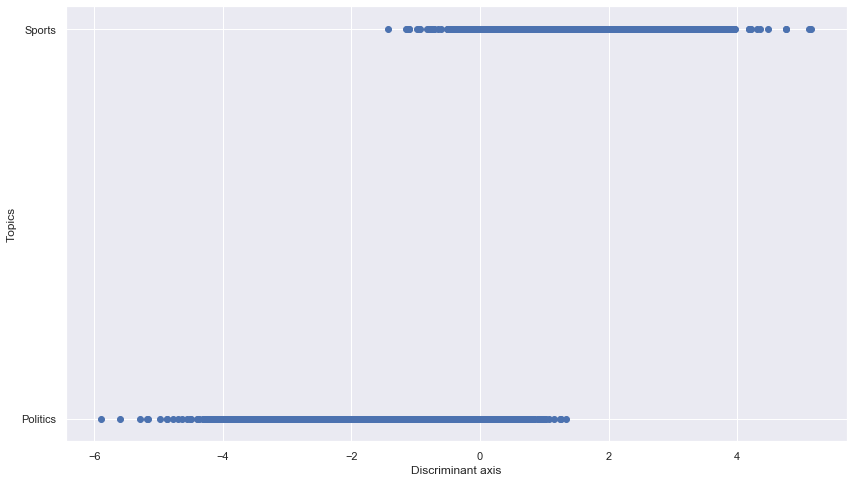

In [39]:
fda = LinearDiscriminantAnalysis()

fda_object = fda.fit(X_train, y_train)

X_fda = fda_object.transform(X_train)

plt.scatter(X_fda, y_train)
plt.xlabel("Discriminant axis")
plt.ylabel("Topics")

In [40]:
# cross_validation = LeaveOneOut()

# lda = LinearDiscriminantAnalysis()

# lda_object = lda.fit(X_train, y_train)

# predicted_y_LDA = cross_val_predict(lda_object, X_train, y_train, cv=cross_validation, n_jobs=-1)

# accuracy_LDA = accuracy_score(y_train, predicted_y_LDA)